# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Load Data sets

In [7]:
import datetime
import pickle
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,r2_score,accuracy_score,precision_recall_curve,classification_report, make_scorer, fbeta_score
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import RandomizedSearchCV
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Importing necessary libraries
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

import progressbar

In [8]:
import pandas as pd
import numpy as np
import math
import json
import re
import os
from joblib import dump, load
#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_raw = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [9]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [10]:
profile_raw.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [13]:
profile_raw.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
profile_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [15]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

## Cleaning datasets

### Clean portfolio data

In [16]:
def clean_portfolio (data):
    
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration']
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return(cleaned_portfolio)

In [17]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio.head()

,reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


### Customer profile data EDA

In [18]:
profile = profile_raw

__Detrmine %age of missing values in profile data__

In [19]:
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

__Compute gender attribute distribution__

In [20]:
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
gender_counts

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [21]:
profile[profile['income'].notnull()].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


__Evaluate what year customer became reward member__

In [22]:
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    
    INPUT:
        elem: String that stores a date in the %Y%m%d format

    OUTPUT:
        datetimeobj: Datetime object"""
    return datetime.strptime(str(elem), '%Y%m%d')

In [23]:
became_member_on = profile['became_member_on'].apply(convert_to_datetime)

start_year = became_member_on.apply(lambda elem: elem.year).value_counts()
start_year *= 100 / start_year.sum()
start_year

2017    38.052941
2018    24.694118
2016    20.741176
2015    10.764706
2014     4.064706
2013     1.682353
Name: became_member_on, dtype: float64

__Evaluate what month customer became reward program member__

In [24]:
start_month = became_member_on.apply(lambda elem: elem.month).value_counts()
start_month *= 100 / start_month.sum()
start_month

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

In [25]:
def update_column_name(dataframe,
                       old_column_name,
                       new_column_name):
    """ Updates a Pandas DataFrame column name

    INPUT:
        dataframe: Pandas DataFrame object

        old_column_name: String that stores the old column name

        new_column_name: String that stores the new column name

    OUTPUT:
        column_names: np.array that stores the updated Pandas DataFrame
                      column names"""
    column_names = dataframe.columns.values
    
    select_data = np.array([elem == old_column_name for elem in column_names])

    column_names[select_data] = new_column_name
        
    return column_names

__Clean the customer profile data__:
1. Remove customers with missing income data
2. Remove customer profiles where the gender attribute is missing
3. Change the name of the 'id' column to 'customerid'
4. Transform the 'became_member_on' column to a datetime object
5. One hot encode a customer's membership start year
6. One hot encode a customer's age range
7. Transform a customer's gender from a character to a number

In [26]:
def clean_profile(profile):
    """ Transforms a DataFrame that contains demographic data for each 
    customer
    
    INPUT:
        (Optional) data_dir: String that stores the full path to the
                             data directory
    
    OUTPUT:
        profile: DataFrame that contains demographic data for each 
                 customer
    """

    # Remove customers with N/A income data
    profile = profile[profile['income'].notnull()]

    # Remove customers with unspecified gender
    profile = profile[profile['gender'] != 'O']
    profile = profile.reset_index(drop=True)

    # Change the name of the 'id' column to 'customerid'
    profile.columns = update_column_name(profile,
                                         'id',
                                         'customerid')

    # Initialize a list that describes the desired DataFrame column
    # ordering
    column_ordering = ['customerid',
                       'gender',
                       'income']

    # Transform the 'became_member_on' column to a datetime object
    profile['became_member_on'] =\
        profile['became_member_on'].apply(convert_to_datetime)

    # One hot encode a customer's membership start year
    profile['membershipstartyear'] =\
        profile['became_member_on'].apply(lambda elem: elem.year)

    membershipstartyear_df = pd.get_dummies(profile['membershipstartyear'])
    column_ordering.extend(membershipstartyear_df.columns.values)

    # One hot encode a customer's age range
    min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
    max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

    profile['agerange'] =\
        pd.cut(profile['age'],
               (range(min_age_limit,max_age_limit + 10, 10)),
               right=False)

    profile['agerange'] = profile['agerange'].astype('str')

    agerange_df = pd.get_dummies(profile['agerange'])
    column_ordering.extend(agerange_df.columns.values)

    # Transform a customer's gender from a character to a number
    binarizerobj = LabelBinarizer()
    profile['gender'] = binarizerobj.fit_transform(profile['gender'])

    gender_integer_map = {}
    for elem in binarizerobj.classes_:
        gender_integer_map[elem] = binarizerobj.transform([elem])[0,0]

    # Appened one hot encoded age range and membership start year variables
    profile = pd.concat([profile,
                         agerange_df,
                         membershipstartyear_df], axis=1)

    # Drop depcreated columns
    profile = profile.drop(columns=['age',
                                    'agerange',
                                    'became_member_on',
                                    'membershipstartyear'])

    # Return a DataFrame with "clean" customer profile data
    return profile[column_ordering], gender_integer_map

In [27]:
(profile,
 gender_integer_map) = clean_profile(profile)

print("Number of user profiles: %d" % (profile.shape[0]))

Number of user profiles: 14613


In [28]:
profile.describe()

,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
count,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000
mean,0.580579,65435.707931,0.018545,0.045028,0.107302,0.204749,0.377062,0.247314,0.014029,0.001095,0.092589,0.102854,0.155273,0.238486,0.202012,0.120235,0.056183,0.017245
std,0.493481,21633.524110,0.134916,0.207374,0.309507,0.403532,0.484667,0.431466,0.117613,0.033073,0.289865,0.303778,0.362177,0.426173,0.401515,0.325248,0.230282,0.130187
min,0.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,49000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,64000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,80000.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
print(gender_integer_map)

{'F': 0, 'M': 1}


__Distribution of age and income of customer__

In [30]:
def display_customer_profile(data):
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    user_age = data['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
    user_age.set_xlabel("Customer Age")
    
    # Display Histogram of User Income
    plt.figure()
    user_income = data['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
    user_income.set_xlabel("Income")

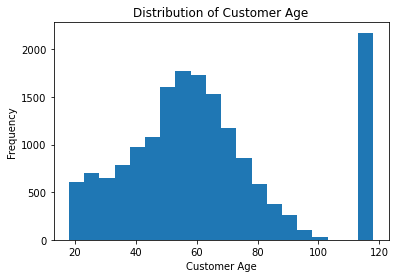

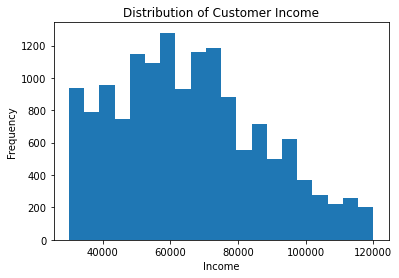

In [31]:
display_customer_profile(profile_raw)

__Plot income distribution as a function of gender__

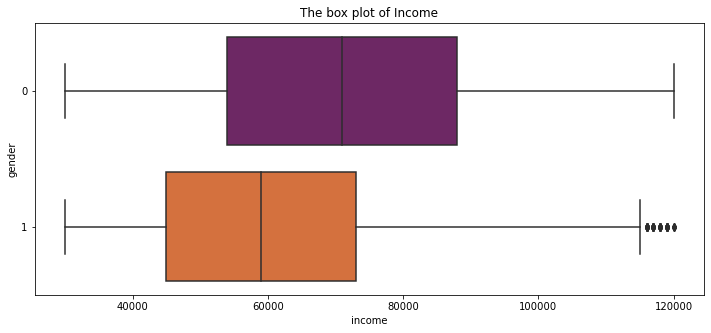

In [77]:
plt.figure(figsize=(12,5))
plt.title("The box plot of Income")
sns.boxplot(y="gender", x="income", data = profile
            ,orient="h", palette = 'inferno')

Average income among male gender is higher than female, however minimum and maximum income for both male and female gender is approximately the same

__Compute custome rgender distribution__

In [33]:
profile['gender'].value_counts()

1    8484
0    6129
Name: gender, dtype: int64

### Transcript Data EDA

In [34]:
#Clean transcript data
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


In [35]:
total_transactions = event_counts['count'].sum()

percentage_transactions = 100 * event_counts.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_counts.iloc[1:]['count'].sum() / total_transactions

print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


In [36]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [37]:
profile.head()

,customerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


__Clean Transcript data__:
1. Change the name of the 'person' column to 'customerid'
2. Remove customer id's that are not in the customer profile DataFrame
3. Convert time variable units from hours to days
4. Change the name of the 'time' column to 'timedays'
5. Create a DataFrame that describes offers
6. Create an offerid column
7. Parse the offer event type (i.e. 'received', 'viewed', or 'completed')
8. One hot encode customer offer events
9. Create a DataFrame that describes customer transaction events
10. Parse customer transaction values

In [38]:
def clean_transcript(profile,transcript):
    """ Transforms a DataFrame that contains records for transactions, offers
    received, offers viewed, and offers completed

    INPUT:
        profile: DataFrame that contains demographic data for each 
                 customer

    OUTPUT:
        offer_data: DataFrame that describes customer offer data

        transaction: DataFrame that describes customer transactions
    """

    # Change the name of the 'person' column to 'customerid'
    transcript.columns = update_column_name(transcript,
                                            'person',
                                            'customerid')
    profile.columns = update_column_name(profile,
                                            'id',
                                            'customerid')
    
    # Remove customer id's that are not in the customer profile DataFrame
    select_data = transcript['customerid'].isin(profile['customerid'])
    transcript = transcript[select_data]

    percent_removed = 100 * (1 - select_data.sum() / select_data.shape[0])
    print("Percentage of transactions removed: %.2f %%" % percent_removed)

    # Convert from hours to days
    transcript['time'] /= 24.0
    
    # Change the name of the 'time' column to 'timedays'
    transcript.columns = update_column_name(transcript,'time','timedays')

    # Select customer offers
    pattern_obj = re.compile('^offer (?:received|viewed|completed)')

    h_is_offer = lambda elem: pattern_obj.match(elem) != None

    is_offer = transcript['event'].apply(h_is_offer)

    offer_data = transcript[is_offer].copy()
    offer_data = offer_data.reset_index(drop=True)

    # Initialize a list that describes the desired output DataFrame
    # column ordering
    column_order = ['offerid', 'customerid', 'timedays']

    # Create an offerid column
    offer_data['offerid'] = offer_data['value'].apply(lambda elem: list(elem.values())[0])

    # Transform a column that describes a customer offer event
    pattern_obj = re.compile('^offer ([a-z]+$)')

    h_transform = lambda elem: pattern_obj.match(elem).groups(1)[0]

    offer_data['event'] = offer_data['event'].apply(h_transform)

    # One hot encode customer offer events
    event_df = pd.get_dummies(offer_data['event'])
    column_order.extend(event_df.columns.values)

    # Create a DataFrame that describes customer offer events
    offer_data = pd.concat([offer_data, event_df], axis=1)
    offer_data.drop(columns=['event', 'value'])
    offer_data = offer_data[column_order]

    # Select customer transaction events
    transaction = transcript[is_offer == False]
    transaction = transaction.reset_index(drop=True)

    # Transform customer transaction event values
    transaction['amount'] = transaction['value'].apply(lambda elem: list(elem.values())[0])

    # Create a DataFrame that describes customer transactions
    transaction = transaction.drop(columns=['event', 'value'])
    column_order = ['customerid', 'timedays', 'amount']
    transaction = transaction[column_order]

    return offer_data, transaction

In [39]:
offer_data, transaction = clean_transcript(profile,transcript)

Percentage of transactions removed: 12.31 %


c:\users\ss10265\appdata\local\continuum\anaconda3\envs\mypython3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
transaction.head()

,customerid,timedays,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [41]:
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


In [42]:
profile.head()

,customerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [43]:
cleaned_portfolio.head()

,reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [44]:
cleaned_portfolio.columns = update_column_name(cleaned_portfolio,
                                            'id',
                                            'offerid')

In [45]:
cleaned_portfolio.columns = update_column_name(cleaned_portfolio,
                                            'duration',
                                            'durationdays')

## Combining Transaction, Demographic and Offer data

In [46]:
def create_offeranalysis_dataset(profile,
                                 portfolio,
                                 offer_data,
                                 transaction):
    """ Creates an analytic dataset from the following Starbucks challenge 
    datasets:

    * portfolio.json - Contains offer ids and meta data (duration, type,
                       etc.)

    * profile.json - demographic data for each customer

    * transcript.json - records for transactions, offers received, offers
                        viewed, and offers completed
                        
    INPUT:
        profile: DataFrame that contains demographic data for each 
                 customer

        portfolio: Contains offer ids and meta data (duration, type, etc.)

        offer_data: DataFrame that describes customer offer data

        transaction: DataFrame that describes customer transactions

    OUTPUT:
        clean_data: DataFrame that characterizes the effectiveness of
                    customer offers"""
    clean_data = []
    customerid_list = offer_data['customerid'].unique()

    widgets=[' [',
             progressbar.Timer(), '] ',
             progressbar.Bar(),
             ' (',
             progressbar.ETA(),
             ') ']

    for idx in range(len(customerid_list)):

        clean_data.extend(create_combined_records(customerid_list[idx],
                                                  portfolio,
                                                  profile,
                                                  offer_data,
                                                  transaction))

    clean_data = pd.DataFrame(clean_data)

    clean_data = clean_data.sort_values('time')
    return clean_data.reset_index(drop=True)

In [47]:
def create_combined_records(customer_id,
                            portfolio,
                            profile,
                            offer_data,
                            transaction):
    """ 
    Creates a list of dictionaries that describes the effectiveness of
    offers to a specific customer

    INPUT:
        customer_id: String that refers to a specific customer

        profile: DataFrame that contains demographic data for each 
                 customer
                 
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)

        offer_data: DataFrame that describes customer offer data

        transaction: DataFrame that describes customer transactions
    
    OUTPUT:
        rows: List of dictionaries that describes the effectiveness of
              offers to a specific customer
    """
    # Select a customer's profile
    cur_customer = profile[profile['customerid'] == customer_id]

    # Select offer data for a specific customer
    select_offer_data = offer_data['customerid'] == customer_id
    customer_offer_data = offer_data[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='customerid')
    customer_offer_data = customer_offer_data.reset_index(drop=True)

    # Select transactions for a specific customer
    select_transaction = transaction['customerid'] == customer_id
    customer_transaction_data = transaction[select_transaction]

    customer_transaction_data =\
        customer_transaction_data.drop(columns='customerid')

    customer_transaction_data =\
        customer_transaction_data.reset_index(drop=True)

    # Initialize DataFrames that describe when a customer receives,
    # views, and completes an offer
    event_type = ['completed',
                  'received',
                  'viewed']

    offer_received =\
        customer_offer_data[customer_offer_data['received'] == 1]

    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    offer_viewed =\
        customer_offer_data[customer_offer_data['viewed'] == 1]

    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    offer_completed =\
        customer_offer_data[customer_offer_data['completed'] == 1]

    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)

    # Iterate over each offer a customer receives
    rows = []
    for idx in range(offer_received.shape[0]):

        # Initialize the current offer id
        cur_offer_id = offer_received.iloc[idx]['offerid']

        # Look-up a description of the current offer
        cur_offer = portfolio.loc[portfolio['offerid'] == cur_offer_id]
        durationdays = cur_offer['durationdays'].values[0]

        # Initialize the time period when an offer is valid
        cur_offer_startime = offer_received.iloc[idx]['timedays']

        cur_offer_endtime =\
            offer_received.iloc[idx]['timedays'] + durationdays

        # Initialize a boolean array that select customer transcations that
        # fall within the valid offer time window
        select_transaction =\
            np.logical_and(customer_transaction_data['timedays'] >=
                           cur_offer_startime,
                           customer_transaction_data['timedays'] <=
                           cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer completes an offer (this array may not contain any True
        # values)
        select_offer_completed =\
            np.logical_and(offer_completed['timedays'] >= cur_offer_startime,
                           offer_completed['timedays'] <= cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer views an offer (this array may not contain any True
        # values)
        select_offer_viewed =\
            np.logical_and(offer_viewed['timedays'] >= cur_offer_startime,
                           offer_viewed['timedays'] <= cur_offer_endtime)

        # Determine whether the current offer was successful
        cur_offer_successful =\
            select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0

        # Select customer transcations that occurred within the current offer
        # valid time window
        cur_offer_transactions = customer_transaction_data[select_transaction]

        # Initialize a dictionary that describes the current customer offer
        cur_row = {'offerid': cur_offer_id,
                   'customerid': customer_id,
                   'time': cur_offer_startime,
                   'offersuccessful': int(cur_offer_successful),
                   'totalamount': cur_offer_transactions['amount'].sum()}

        cur_row.update(cur_offer.iloc[0,1:].to_dict())

        cur_row.update(cur_customer.iloc[0,1:].to_dict())

        # Update a list of dictionaries that describes the effectiveness of 
        # offers to a specific customer
        rows.append(cur_row)

    return rows


In [48]:
clean_data_csvfile = "./data/clean_data.csv"

if os.path.exists(clean_data_csvfile):
    clean_data = pd.read_csv(clean_data_csvfile)
else:
    clean_data = create_offeranalysis_dataset(profile,
                                              cleaned_portfolio,
                                              offer_data,
                                              transaction)

    clean_data.to_csv(clean_data_csvfile, index=False)
    
clean_data = clean_data.drop(columns=['time',
                                      'customerid',
                                      'email',
                                      'informational'])

column_ordering = ['offerid', 'totalamount']
column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])

clean_data = clean_data[column_ordering]
clean_data.head()


,offerid,totalamount,offersuccessful,difficulty,durationdays,web,mobile,social,bogo,discount,...,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,7,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,48.31,1,10,5,1,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,5a8bc65990b245e5a138643cd4eb9837,23.43,0,0,3,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,52.24,0,5,7,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,fafdcd668e3743c1bb461111dcafc2a4,5.12,0,10,10,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0


In [49]:
clean_data.columns

Index(['offerid', 'totalamount', 'offersuccessful', 'difficulty',
       'durationdays', 'web', 'mobile', 'social', 'bogo', 'discount', 'gender',
       'income', '2013', '2014', '2015', '2016', '2017', '2018', '[10, 20)',
       '[100, 110)', '[20, 30)', '[30, 40)', '[40, 50)', '[50, 60)',
       '[60, 70)', '[70, 80)', '[80, 90)', '[90, 100)'],
      dtype='object')

In [50]:
clean_data.isna().sum()

offerid            0
totalamount        0
offersuccessful    0
difficulty         0
durationdays       0
web                0
mobile             0
social             0
bogo               0
discount           0
gender             0
income             0
2013               0
2014               0
2015               0
2016               0
2017               0
2018               0
[10, 20)           0
[100, 110)         0
[20, 30)           0
[30, 40)           0
[40, 50)           0
[50, 60)           0
[60, 70)           0
[70, 80)           0
[80, 90)           0
[90, 100)          0
dtype: int64

# Modeling

**Objective:** Objective of this modeling experscise is to build a machine learning model to predict whether or not someone will respond to an offer

## Defning features for model

In [52]:
data_y = clean_data['offersuccessful']
data_x = clean_data.drop(['offersuccessful','offerid','totalamount'], axis = 1)

In [53]:
variable_names = data_x.columns

In [54]:
variable_names

Index(['difficulty', 'durationdays', 'web', 'mobile', 'social', 'bogo',
       'discount', 'gender', 'income', '2013', '2014', '2015', '2016', '2017',
       '2018', '[10, 20)', '[100, 110)', '[20, 30)', '[30, 40)', '[40, 50)',
       '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)', '[90, 100)'],
      dtype='object')

## Creating train, validation and test set

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [56]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(data_x,
                            data_y,
                            test_size=0.3,
                            random_state=45)

### Evaluate baseline performace

In [57]:
baseline_accuracy = accuracy_score(y_train,np.ones(len(y_train)))

print("Baseline accuracy: %.3f" % (baseline_accuracy))

Baseline accuracy: 0.469


In [79]:
f1_score(y_train,np.ones(len(y_train)))

0.6389469471250055

### Construct simple logistic regression model

In [80]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=45).fit(X_train, y_train)

In [81]:
Y_pred_train=lr.predict(X_train)
Y_pred_test=lr.predict(X_test)

# Creating a dictionary with results of train,validation and test

model_results=dict({'F1_train':f1_score(y_train,Y_pred_train),'Precision_train':precision_score(y_train,Y_pred_train),'Recall_train':recall_score(y_train,Y_pred_train),'F1_test':f1_score(y_test,Y_pred_test),'Precision_test':precision_score(y_test,Y_pred_test),'Recall_test':recall_score(y_test,Y_pred_test)})

# Convert dictionary to dataframe and transpose

model_results=pd.DataFrame.from_dict(model_results , orient ='index')
model_results=model_results.transpose()
model_results

,F1_train,Precision_train,Recall_train,F1_test,Precision_test,Recall_test
0,0.55811,0.528845,0.590804,0.554086,0.526087,0.585232


In [82]:
accuracy_score(Y_pred_train,y_train)

0.5608050709011305

### Construct a Random forest model

In [83]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

rf = RandomForestClassifier(n_estimators = 80, random_state = 42, max_depth= 3)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, n_estimators=80, random_state=42)

In [84]:
Y_pred_train=rf.predict(X_train)
Y_pred_test=rf.predict(X_test)

# Creating a dictionary with results of train,validation and test

model_results=dict({'F1_train':f1_score(y_train,Y_pred_train),'Precision_train':precision_score(y_train,Y_pred_train),'Recall_train':recall_score(y_train,Y_pred_train),'F1_test':f1_score(y_test,Y_pred_test),'Precision_test':precision_score(y_test,Y_pred_test),'Recall_test':recall_score(y_test,Y_pred_test)})

# Convert dictionary to dataframe and transpose

model_results=pd.DataFrame.from_dict(model_results , orient ='index')
model_results=model_results.transpose()
model_results

,F1_train,Precision_train,Recall_train,F1_test,Precision_test,Recall_test
0,0.727799,0.649205,0.828044,0.726764,0.650556,0.823194


In [85]:
accuracy_score(Y_pred_train,y_train)

0.7092291271863904

### Construct a adaboost model

In [86]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators = 100, random_state = 42)
ada.fit(X_train, y_train)


AdaBoostClassifier(n_estimators=100, random_state=42)

In [87]:
Y_pred_train=ada.predict(X_train)
Y_pred_test=ada.predict(X_test)

# Creating a dictionary with results of train,validation and test

model_results=dict({'F1_train':f1_score(y_train,Y_pred_train),'Precision_train':precision_score(y_train,Y_pred_train),'Recall_train':recall_score(y_train,Y_pred_train),'F1_test':f1_score(y_test,Y_pred_test),'Precision_test':precision_score(y_test,Y_pred_test),'Recall_test':recall_score(y_test,Y_pred_test)})

# Convert dictionary to dataframe and transpose

model_results=pd.DataFrame.from_dict(model_results , orient ='index')
model_results=model_results.transpose()
model_results

,F1_train,Precision_train,Recall_train,F1_test,Precision_test,Recall_test
0,0.721291,0.689757,0.755846,0.718173,0.689939,0.748818


In [88]:
accuracy_score(Y_pred_train,y_train)

0.7257836154130999

__Conclusion__:We are currently similar performance from both random forest and adaboost model with random forest giving slighly better performance and hence we will go ahead with it

Text(0.5, 1.0, 'Random Forest Estimated Feature Importance')

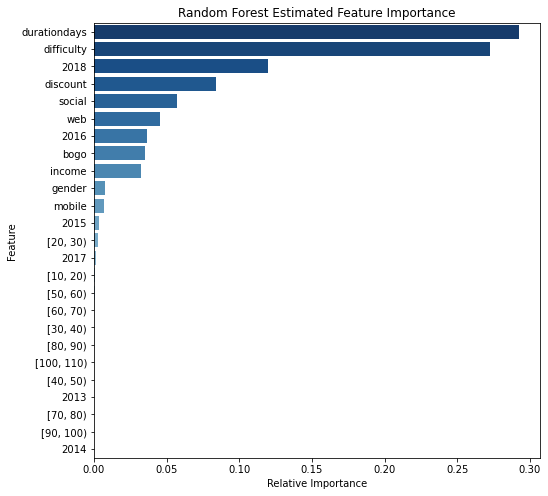

In [76]:
relative_importance = rf.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')